In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [2]:
import pickle
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, RationalQuadratic, WhiteKernel, ConstantKernel as C
from itertools import product
from matplotlib.colors import LogNorm
from os.path import join
import seaborn as sns
from scipy.stats import norm, rayleigh, gamma, t, chi2, cauchy, gaussian_kde
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

from aeff_calculations import setup_aeff_grid, aeff_rotation
from settings import poles
from tools import get_mids

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
BASEPATH = "/home/lisajsch/repos/Plenum/"
plt.style.use(join(BASEPATH, "style.mplstyle"))

filname = join(BASEPATH, "resources/Linefit_angular_resolution_dataframe.csv")
dat = np.genfromtxt(filname, delimiter=",", names=True)
aeff = dat["aeffs"]
dat.dtype.names


('event_id',
 'resolution_linefit',
 'resolution_linefitNew',
 'zenith_angle',
 'zenith_linefit',
 'muon_energy',
 'aeffs')

# angular resolution

In [4]:
logE_bins = np.linspace(3, 6, 31) # 10 bins per decade
logE_mids = get_mids(logE_bins)


Transformation of Psi from log10(psi) to psi^2


$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$

All events used: True


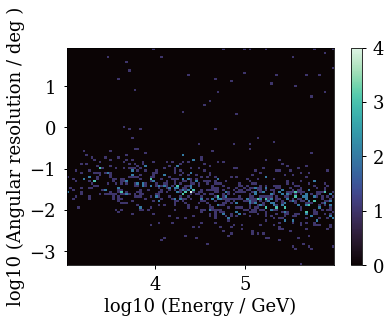

In [5]:
## raw angular resolution matrix
plt.xlabel("log10 (Energy / GeV)")
plt.ylabel("log10 (Angular resolution / deg )")
n, xbins, ybins, image = plt.hist2d(
    np.log10(dat["muon_energy"]), np.log10(dat["resolution_linefitNew"]), bins=100
)
plt.colorbar()
print(f"All events used: {len(dat)==np.sum(n)}")


(0.0, 0.04000000000000001)

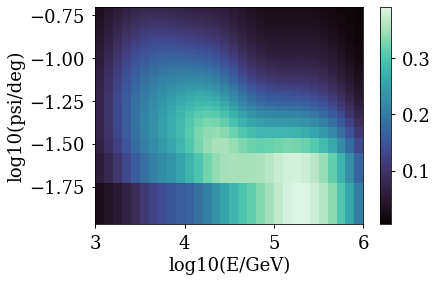

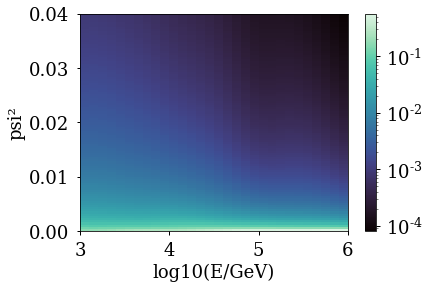

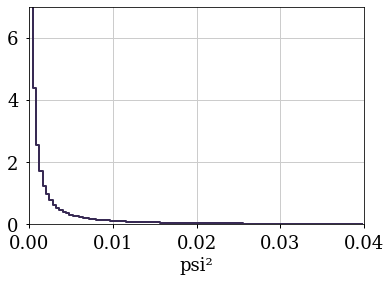

In [6]:
## set up the psi2-energy function and binning
e_psi_kdes = gaussian_kde(
    (np.log10(dat["muon_energy"]), np.log10(dat["resolution_linefitNew"]))
)

# psi² representation
delta_psi_max = 0.2
psi2_bins = np.linspace(0, delta_psi_max**2, num=101)
psi2_mids = get_mids(psi2_bins)
log_psi_mids = np.log10(np.sqrt(psi2_mids))
# KDE was produced in log(E_true) and log(Psi)
e_eval, psi_eval = np.meshgrid(logE_mids, log_psi_mids)
psi_kvals = e_psi_kdes([e_eval.flatten(), psi_eval.flatten()]).reshape(
    len(log_psi_mids), len(logE_mids)
)

# new grid for analysis in psi^2 and e_true
e_grid, psi_grid = np.meshgrid(logE_mids, psi2_mids)
# transform to psi^2
e_psi2_grid = psi_kvals / psi_grid / 2 / np.log(10)
# normalize per energy to ensure that signal event numbers are not changed
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)

plt.figure()
plt.pcolormesh(logE_mids, log_psi_mids, psi_kvals)
plt.colorbar()
plt.ylabel("log10(psi/deg)")
plt.xlabel("log10(E/GeV)")


plt.figure()
plt.pcolormesh(logE_mids, psi2_mids, e_psi2_grid, norm=LogNorm())
plt.colorbar()
plt.ylabel("psi²")
plt.xlabel("log10(E/GeV)")

plt.figure()
plt.plot(psi2_mids, e_psi2_grid.sum(axis=1), ds="steps-mid")
plt.xlabel("psi²")
plt.ylim(0, 7)
plt.xlim(0, delta_psi_max**2)


In [7]:
with open("../../resources/pone_muon_e-psi2.pckl", "wb") as f:
    pickle.dump((logE_bins, psi2_bins, psi_kvals), f)

# effective area

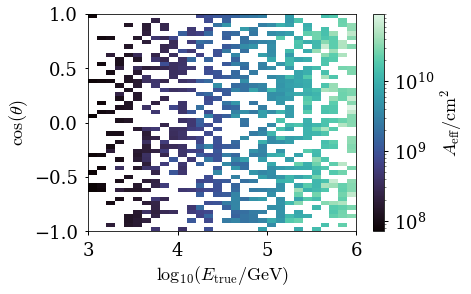

In [8]:
coszen_bins = np.linspace(-1, 1, 51)
coszen_mids = get_mids(coszen_bins)

n_aeff, xbins, ybins, image = plt.hist2d(
    np.log10(dat["muon_energy"]),
    np.cos(np.deg2rad(dat["zenith_angle"])),
    bins=[logE_bins, coszen_bins],
    weights=aeff, 
    norm=LogNorm(),
)
plt.colorbar(label=r"$A_{\rm eff} / {\rm cm^2}$")
plt.ylabel(r"$\cos(\theta)$")
plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")

n_counts, xbins, ybins =np.histogram2d(
    np.log10(dat["muon_energy"]),
    np.cos(np.deg2rad(dat["zenith_angle"])),
    bins=[logE_bins, coszen_bins],
)

In [9]:
# select bins with nonzero aeff as input
mask = n_aeff > 0
input_aeff = np.log10(n_aeff[mask])
input_counts = n_counts[mask]
# prepare the input data
input_logE, input_coszen_ = np.meshgrid(logE_mids, coszen_mids, indexing="ij")
input_logE = input_logE[mask]
input_coszen_ = input_coszen_[mask]
input_X = np.array([input_logE, input_coszen_]).T

# define kernel
kernel = C(1, (1e-3, 1e3)) + Matern(nu=2.5) + WhiteKernel() + RationalQuadratic()
gp = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=15, alpha=1/input_counts, #error estimate
)
# fit the kernel to input data
gp.fit(input_X, input_aeff)

# Evaluation space
x1x2 = np.array(list(product(logE_mids, coszen_mids)))
# Evaluation
aeff_pred, MSE = gp.predict(x1x2, return_std=True)

aeff_mesh = np.reshape(aeff_pred, (len(logE_mids), len(coszen_mids)))


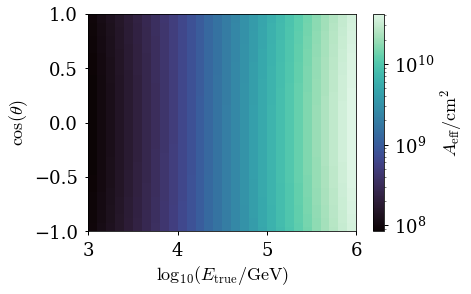

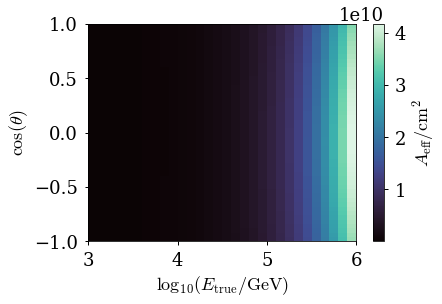

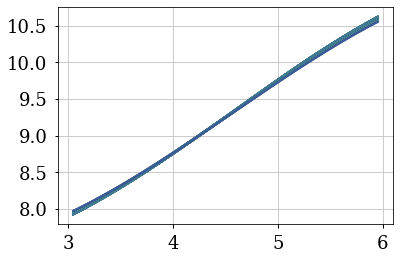

In [10]:

plt.figure()
plt.pcolormesh(logE_bins, coszen_bins, 10**aeff_mesh.T, norm=LogNorm())
plt.colorbar(label=r"$A_{\rm eff} / {\rm cm^2}$")
plt.ylabel(r"$\cos(\theta)$")
plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
plt.figure()
plt.pcolormesh(logE_bins, coszen_bins, 10**aeff_mesh.T)
plt.colorbar(label=r"$A_{\rm eff} / {\rm cm^2}$")
plt.ylabel(r"$\cos(\theta)$")
plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")

plt.figure()
_ = plt.plot(logE_mids, aeff_mesh)


# aeff rotation


In [11]:
from aeff_calculations import setup_aeff_grid

In [12]:
coszen_width = np.diff(coszen_bins)
ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

aeffs = {}
aeffs["local"] =  10**aeff_mesh
aeffs["raw"] = n_aeff

det = "P-ONE"
grid2d, eq_coords = setup_aeff_grid(aeffs["local"], coszen_mids, ra_mids, ra_width, local=True)
aeffs["equatorial"] =  aeff_rotation(
    poles[det]["lat"], poles[det]["lon"], eq_coords, grid2d, ra_width
)

grid2d, eq_coords = setup_aeff_grid(aeffs["raw"], coszen_mids, ra_mids, ra_width, local=True)
aeffs["equatorial_raw"] =  aeff_rotation(
    poles[det]["lat"], poles[det]["lon"], eq_coords, grid2d, ra_width
)


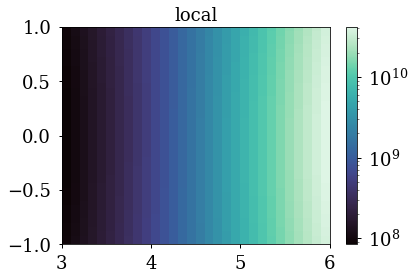

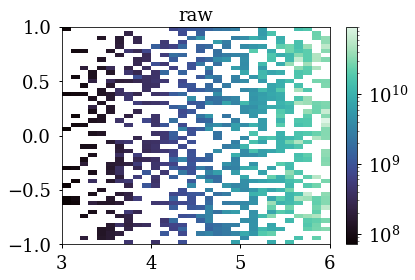

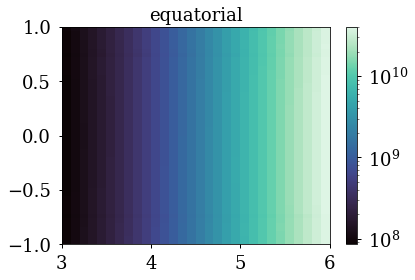

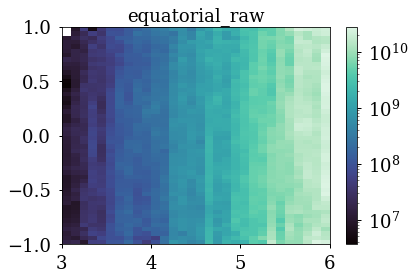

In [13]:
for key in aeffs:
    plt.figure()
    plt.pcolormesh(logE_bins, coszen_bins, aeffs[key].T, norm=LogNorm())
    plt.colorbar()
    plt.title(key)


In [14]:
pd.to_pickle(
    (coszen_bins, logE_bins, aeffs),
    join(BASEPATH, "resources/pone_muon_aeff_with-eq.pckl"),
)


# energy resolution

it's magic ✧･ﾟ:*✧･ﾟ:

In [15]:
from scipy.special import erf
from scipy.interpolate import RegularGridInterpolator

## binning

In [16]:
bin_size = 0.1 # 10 per decade
logE_min = 2.5
logE_max = 9.
logE_reco_bins = np.arange(logE_min, logE_max+bin_size, step=bin_size)
logE_reco_mids = get_mids(logE_reco_bins)

logE_reso_bins = np.arange(logE_min, logE_max, step=bin_size)
logE_reso_mids = get_mids(logE_reso_bins)

## calculation

In [17]:
def double_erf(x, shift_l, shift_r, sigma):
    # normalized such that ig goes from 0 to 1 and back to 0
    return (erf((x - shift_l) / sigma) + 1) * (-erf((x - shift_r) / sigma) + 1) / 4

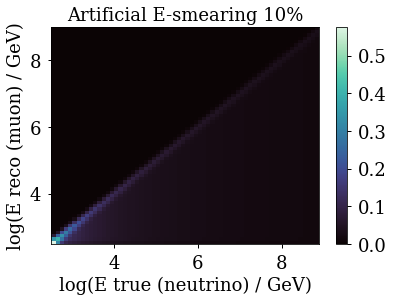

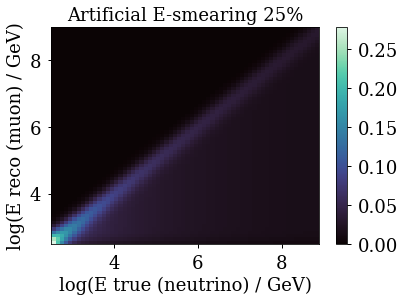

In [18]:
for res in [0.1, 0.25]:
    dx = logE_reco_bins[1] - logE_reco_bins[0]
    HE_2D = []
    sigma_S = sigma_N = res  # energy resolution in log10(E)

    for e_t in logE_reso_mids:
        mu_N = e_t
        # energy resolution of the muon in log(E)
        # and slope shape
        shift_r = mu_N - sigma_S
        shift_l = logE_min # mu_N + np.log10(1 - 0.2) # modeling mean inelasticity y ~ 20% at E=10⁹ GeV

        norbert = norm.pdf(logE_reco_mids, loc=mu_N, scale=sigma_N)
        # normalize such that the plateau is half as high as the gauss
        siggi_norm = norm.pdf(mu_N, loc=mu_N, scale=sigma_N) / 2
        siggi = double_erf(logE_reco_mids, shift_l, shift_r, sigma_S)
        siggi *= siggi_norm

        combined = siggi + norbert
        combined /= np.sum(combined * dx)  # normalize
        HE_2D.append(combined)
    HE_2D = np.array(HE_2D).T
    HE_2D /= np.sum(HE_2D, axis=0)

    plt.figure()
    plt.pcolormesh(logE_reso_bins, logE_reco_bins, HE_2D)
    plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
    plt.xlim(np.min(logE_reso_bins), np.max(logE_reso_bins))
    plt.colorbar()
    plt.title(f"Artificial E-smearing {int(res*100)}%")
    plt.ylabel("log(E reco (muon) / GeV)")
    plt.xlabel("log(E true (neutrino) / GeV)")

    ## save
    if True:
        rgi = RegularGridInterpolator((logE_reco_mids, logE_reso_mids), HE_2D)
        with open(f"../../resources/pone_muon_energy_smearing_rgi_{int(res*100)}-res.pckl", "wb") as f:
            pickle.dump(rgi, f)

        with open(f"../../resources/pone_muon_energy_smearing_2D_{int(res*100)}-res.pckl", "wb") as f:
            pickle.dump((HE_2D, logE_reso_bins, logE_reco_bins), f)

# resolution vs zen

Pretty constant in cos(zen) -> not used further

All events used: False


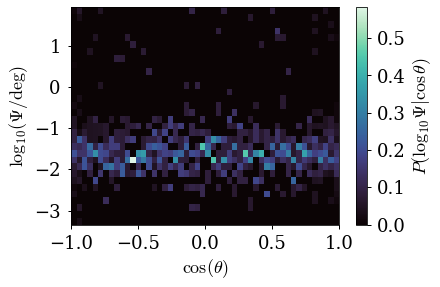

In [19]:
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel(r"$\log_{10}(\Psi / \deg)$")
n, xbins, ybins = np.histogram2d(
    np.cos(dat["zenith_angle"]), np.log10(dat["resolution_linefitNew"]), bins=[coszen_bins, 32]
)
n = n.T / np.sum(n, axis=1)
plt.pcolormesh(xbins, ybins, n)
plt.colorbar(label=r"$P(\log_{10}\Psi | \cos\theta)$")
print(f"All events used: {len(dat)==np.sum(n)}")
